In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset
import os
import copy
from tensorboardX import SummaryWriter
from PIL import Image
import torchvision.transforms as transforms

plt.ion()   # interactive mode
%matplotlib inline

In [2]:
class KDEFDataset(Dataset):
    def __init__(self, root='D:\\Research\\data\\JAFFE', transforms_=None, idx=[]):
        self.transform = transforms_
        self.files = []

        for path, subdirs, files in os.walk(root):
            for name in files:
                self.files.append(os.path.join(path, name))
        
        self.files =  [self.files[i] for i in idx]
        self.classes = {
             "FE":0,
             "AN":1,
             "DI":2,
             "HA":3,
             "NE":4,
             "SA":5,
             "SU":6
        }
        
        for index in range(213):
            filepath = self.files[index % len(self.files)]
            filename = filepath.split('\\')[-1]
            if filename[3:5] not in self.classes:
                print(filepath)

    def __getitem__(self, index):
        filepath = self.files[index % len(self.files)]

        filename = filepath.split('\\')[-1]
        img = self.transform(Image.open(filepath))
        label = self.classes[filename[3:5]]

        return img, label

    def __len__(self):
        return len(self.files)
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

idx = np.random.permutation(210)
idx = {'val': idx[0:7], 'train': idx[7:]}

dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=8,
                                             shuffle=True)
              for x in ['train', 'val']}

dataset_sizes = {x: len(idx[x]) for x in ['train', 'val']}
class_names = 7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images


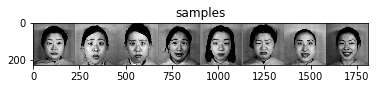

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title='samples')

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [4]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, dataloaders, writer=None, i=0,  num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'saved/resnet_'+str(i)+'.pt')

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

Visualizing the model predictions

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [6]:
accuracies = []
index = list(np.random.permutation(213))

for i in range(30):
    idx = {'val': index[7*i:7*(i+1)], 'train': index[:i*7]+index[((i+1)*7) -1:]}
    dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=28,
                                             shuffle=True)
              for x in ['train', 'val']}

    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, class_names)

    model_ft = model_ft.to(device)
 
    criterion = nn.CrossEntropyLoss()

    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)
    writer = SummaryWriter('./logs/resnet18_kfold_'+str(i))

    model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                     dataloaders, writer, i, num_epochs=25)
    
    accuracies.append(float(best_acc.data[0].cpu().numpy()))
    print("\n\n\n------------------------------------\n Accuracies ", accuracies)
    print("\n\n")

Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.14it/s]


train Loss: 1.9020 Acc: 0.2414


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.3642 Acc: 0.5714

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


train Loss: 1.0455 Acc: 0.6355


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 0.6587 Acc: 0.5714

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.7145 Acc: 0.7537


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 1.4950 Acc: 0.5714

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.4251 Acc: 0.8621


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.3536 Acc: 0.8571

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


train Loss: 0.2554 Acc: 0.9409


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1105 Acc: 1.0000

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.1886 Acc: 0.9606


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.0491 Acc: 1.0000

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.93it/s]


train Loss: 0.0781 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0208 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.81it/s]


train Loss: 0.0514 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 0.0137 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0607 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.42it/s]


val Loss: 0.0161 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.37it/s]


train Loss: 0.0876 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0187 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.0429 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.0159 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


train Loss: 0.0508 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0158 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0656 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.0173 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0361 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0154 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


train Loss: 0.0466 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0182 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


train Loss: 0.0406 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0171 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0357 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0176 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0441 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0183 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0386 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.0199 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0642 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.0207 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0591 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0173 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


train Loss: 0.0453 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.0166 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0414 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.0179 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0647 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0163 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0466 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0188 Acc: 1.0000

Training complete in 0m 41s
Best val Acc: 1.000000


C:\Users\bikas\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number





------------------------------------
 Accuracies  [1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


train Loss: 1.9499 Acc: 0.2069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 1.3857 Acc: 0.2857

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.9826 Acc: 0.6552


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 1.6033 Acc: 0.4286

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.4258 Acc: 0.8571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 1.8256 Acc: 0.4286

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.2780 Acc: 0.9113


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


val Loss: 1.4431 Acc: 0.7143

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.2222 Acc: 0.9261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 1.5316 Acc: 0.7143

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0931 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 1.7931 Acc: 0.7143

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0857 Acc: 0.9803


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 1.8168 Acc: 0.7143

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0493 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 1.7896 Acc: 0.7143

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0276 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 1.7639 Acc: 0.7143

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0377 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.46it/s]


val Loss: 1.7545 Acc: 0.7143

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


train Loss: 0.0609 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.63it/s]


val Loss: 1.7843 Acc: 0.7143

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0285 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.7581 Acc: 0.7143

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0263 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.7465 Acc: 0.7143

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0457 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 1.7589 Acc: 0.7143

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0422 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.46it/s]


val Loss: 1.7336 Acc: 0.7143

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0158 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.7285 Acc: 0.7143

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0283 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 1.7225 Acc: 0.7143

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.0319 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 1.7689 Acc: 0.7143

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0369 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.7945 Acc: 0.7143

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0303 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.7908 Acc: 0.7143

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


train Loss: 0.0303 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.7691 Acc: 0.7143

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0189 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.7354 Acc: 0.7143

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0252 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.46it/s]


val Loss: 1.7263 Acc: 0.7143

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0228 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 1.7275 Acc: 0.7143

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0211 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.7341 Acc: 0.7143

Training complete in 0m 40s
Best val Acc: 0.714286



------------------------------------
 Accuracies  [1.0, 0.7142857142857142]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 1.9836 Acc: 0.2463


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 1.5746 Acc: 0.2857

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 1.0979 Acc: 0.6207


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 1.5477 Acc: 0.5714

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.5469 Acc: 0.8424


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 1.5640 Acc: 0.5714

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.5076 Acc: 0.8276


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 3.3463 Acc: 0.2857

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.3460 Acc: 0.8966


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.8983 Acc: 0.5714

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.1369 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.1918 Acc: 0.8571

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.1059 Acc: 0.9951


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.1479 Acc: 0.8571

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 0.0631 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.0932 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0403 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.1097 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0732 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1030 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0634 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.1160 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0583 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.1325 Acc: 0.8571

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0425 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.1355 Acc: 0.8571

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0373 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.1199 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.98it/s]


train Loss: 0.0500 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.1117 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0467 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.1044 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0406 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.1216 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


train Loss: 0.0693 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.1228 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0451 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.1212 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.0506 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1137 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0541 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1369 Acc: 0.8571

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0404 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1110 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0515 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1089 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0404 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1150 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


train Loss: 0.0525 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.1097 Acc: 1.0000

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 2.0709 Acc: 0.2069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 2.0301 Acc: 0.2857

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33it/s]


train Loss: 1.3134 Acc: 0.5567


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.0718 Acc: 0.5714

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.6784 Acc: 0.7783


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 2.6747 Acc: 0.4286

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.3504 Acc: 0.9163


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.8388 Acc: 0.7143

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33it/s]


train Loss: 0.2367 Acc: 0.9606


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.1339 Acc: 1.0000

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.1019 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.0817 Acc: 1.0000

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


train Loss: 0.0772 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.0787 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.0634 Acc: 0.9951


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.46it/s]


val Loss: 0.0933 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.32it/s]


train Loss: 0.0473 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.1284 Acc: 0.8571

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0839 Acc: 0.9852


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.0987 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


train Loss: 0.0311 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.1122 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0280 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1392 Acc: 0.8571

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0504 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1622 Acc: 0.8571

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31it/s]


train Loss: 0.0344 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.1595 Acc: 0.8571

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0503 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.1262 Acc: 0.8571

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0432 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1134 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0412 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.1231 Acc: 0.8571

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


train Loss: 0.0372 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 0.1273 Acc: 0.8571

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0434 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.1257 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0345 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


val Loss: 0.1205 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0466 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


val Loss: 0.1131 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0223 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1339 Acc: 0.8571

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0306 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.83it/s]


val Loss: 0.1164 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0293 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1331 Acc: 0.8571

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0330 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1087 Acc: 1.0000

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 1.9046 Acc: 0.2956


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 1.5367 Acc: 0.4286

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 1.0404 Acc: 0.6207


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 3.4723 Acc: 0.1429

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.3954 Acc: 0.9113


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 1.7480 Acc: 0.5714

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.4097 Acc: 0.8916


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.9657 Acc: 0.4286

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.3018 Acc: 0.8966


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 1.9030 Acc: 0.5714

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.1372 Acc: 0.9852


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.9354 Acc: 0.5714

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0962 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.8839 Acc: 0.5714

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31it/s]


train Loss: 0.0503 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.8771 Acc: 0.5714

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0469 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.9188 Acc: 0.5714

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0425 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.37it/s]


val Loss: 0.8683 Acc: 0.5714

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0298 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.8693 Acc: 0.5714

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0494 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


val Loss: 0.9071 Acc: 0.5714

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0419 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.8483 Acc: 0.5714

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0869 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.8446 Acc: 0.5714

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0321 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.8171 Acc: 0.5714

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0309 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.7657 Acc: 0.5714

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


train Loss: 0.0334 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.8494 Acc: 0.5714

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0338 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.8501 Acc: 0.5714

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


train Loss: 0.0355 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.8027 Acc: 0.5714

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0256 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.8034 Acc: 0.5714

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


train Loss: 0.0401 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.8696 Acc: 0.5714

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0340 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.8215 Acc: 0.5714

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0475 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.8656 Acc: 0.5714

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0323 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.8981 Acc: 0.5714

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0483 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.8541 Acc: 0.5714

Training complete in 0m 40s
Best val Acc: 0.571429



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 1.9835 Acc: 0.2709


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 1.7399 Acc: 0.4286

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 1.0615 Acc: 0.6158


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.1157 Acc: 0.5714

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.4080 Acc: 0.9015


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.2798 Acc: 0.8571

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.4147 Acc: 0.8571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 4.0934 Acc: 0.0000

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.3235 Acc: 0.9163


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1028 Acc: 1.0000

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


train Loss: 0.1089 Acc: 0.9803


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.0202 Acc: 1.0000

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0481 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.0140 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0397 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0113 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0497 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0107 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0581 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0109 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0413 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0108 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0276 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.0109 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


train Loss: 0.0369 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.92it/s]


val Loss: 0.0114 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.95it/s]


train Loss: 0.0239 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.0124 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


train Loss: 0.0298 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0113 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0701 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0108 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


train Loss: 0.0255 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0119 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0278 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0110 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0206 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 0.0108 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0288 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0113 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31it/s]


train Loss: 0.0245 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.0112 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0271 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0106 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


train Loss: 0.0318 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0112 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0360 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.46it/s]


val Loss: 0.0112 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0304 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0102 Acc: 1.0000

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 2.1026 Acc: 0.2315


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 2.5761 Acc: 0.2857

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 1.3140 Acc: 0.5567


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 1.9006 Acc: 0.4286

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.4968 Acc: 0.8670


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 1.6218 Acc: 0.4286

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.2663 Acc: 0.9113


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 6.0584 Acc: 0.2857

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.2772 Acc: 0.9458


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.6790 Acc: 0.5714

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.1471 Acc: 0.9655


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.3372 Acc: 0.8571

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0519 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.2733 Acc: 0.8571

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0484 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.2548 Acc: 0.8571

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0624 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2306 Acc: 0.8571

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.0472 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2105 Acc: 0.8571

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0257 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1895 Acc: 0.8571

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0263 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1837 Acc: 0.8571

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0294 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.2077 Acc: 0.8571

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0558 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.1859 Acc: 0.8571

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0394 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.2084 Acc: 0.8571

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0459 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1966 Acc: 0.8571

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


train Loss: 0.0481 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2284 Acc: 0.8571

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0469 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.1443 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0376 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.1725 Acc: 0.8571

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0234 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1835 Acc: 0.8571

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0271 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.2194 Acc: 0.8571

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0309 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.1889 Acc: 0.8571

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0314 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.1788 Acc: 0.8571

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0308 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.1744 Acc: 0.8571

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0565 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1965 Acc: 0.8571

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 2.0681 Acc: 0.1921


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 3.0790 Acc: 0.1429

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 1.2997 Acc: 0.5025


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.36it/s]


val Loss: 2.9267 Acc: 0.1429

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.5885 Acc: 0.7833


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.3995 Acc: 0.7143

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.4027 Acc: 0.8768


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 3.6602 Acc: 0.4286

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.1740 Acc: 0.9507


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.2648 Acc: 0.8571

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0856 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


val Loss: 0.0480 Acc: 1.0000

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


train Loss: 0.0702 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0345 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0334 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0877 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.0511 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1218 Acc: 0.8571

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0287 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.1028 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0504 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1171 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


train Loss: 0.0543 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.1316 Acc: 0.8571

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.97it/s]


train Loss: 0.0360 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1304 Acc: 0.8571

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.0394 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.1324 Acc: 0.8571

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0501 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1461 Acc: 0.8571

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0348 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1470 Acc: 0.8571

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0311 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1758 Acc: 0.8571

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0340 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.31it/s]


val Loss: 0.1639 Acc: 0.8571

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0428 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.1447 Acc: 0.8571

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0435 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1326 Acc: 0.8571

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0174 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.1266 Acc: 0.8571

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0271 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1272 Acc: 0.8571

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


train Loss: 0.0256 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.1384 Acc: 0.8571

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0325 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1174 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0189 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.1267 Acc: 0.8571

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


train Loss: 2.0346 Acc: 0.1970


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.8614 Acc: 0.2857

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 1.2149 Acc: 0.5271


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 2.1229 Acc: 0.4286

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.5795 Acc: 0.8177


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 2.1934 Acc: 0.2857

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


train Loss: 0.4361 Acc: 0.8818


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 0.8782 Acc: 0.5714

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.2673 Acc: 0.9310


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.1557 Acc: 1.0000

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


train Loss: 0.1524 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2153 Acc: 0.8571

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


train Loss: 0.0904 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.2746 Acc: 0.8571

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0641 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.2690 Acc: 0.8571

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0518 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.2693 Acc: 0.8571

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0358 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.2490 Acc: 0.8571

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0439 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2138 Acc: 0.8571

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0520 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.1894 Acc: 0.8571

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31it/s]


train Loss: 0.0565 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.2485 Acc: 0.8571

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0492 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.2287 Acc: 0.8571

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0451 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2031 Acc: 0.8571

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


train Loss: 0.0388 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2011 Acc: 0.8571

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0392 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 0.2377 Acc: 0.8571

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0497 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.2116 Acc: 0.8571

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0370 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2060 Acc: 0.8571

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0773 Acc: 0.9852


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.2059 Acc: 0.8571

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0443 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.2250 Acc: 0.8571

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0546 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.2019 Acc: 0.8571

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0407 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.2174 Acc: 0.8571

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0460 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.1958 Acc: 0.8571

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0461 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.1949 Acc: 0.8571

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 1.9198 Acc: 0.3153


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 1.1500 Acc: 0.7143

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.8612 Acc: 0.7438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.9922 Acc: 0.7143

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.6060 Acc: 0.7980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.4493 Acc: 0.8571

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31it/s]


train Loss: 0.3412 Acc: 0.9163


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 1.1908 Acc: 0.5714

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.2461 Acc: 0.9458


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.1780 Acc: 1.0000

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0995 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0461 Acc: 1.0000

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0470 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0179 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0330 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0132 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0205 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0152 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0240 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0165 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0412 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0216 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0409 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0160 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0416 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.0140 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0283 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.0128 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


train Loss: 0.0219 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0144 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0317 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0162 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0422 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0159 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0305 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0145 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0326 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.0130 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0490 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.0145 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0296 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0137 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 0.0282 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0139 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0352 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.0124 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0351 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0139 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


train Loss: 0.0411 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0133 Acc: 1.0000

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 2.1312 Acc: 0.1281


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 2.7523 Acc: 0.1429

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


train Loss: 1.4909 Acc: 0.5074


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 3.3882 Acc: 0.0000

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 1.0601 Acc: 0.6650


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 4.1881 Acc: 0.2857

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.4436 Acc: 0.8768


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 2.3002 Acc: 0.4286

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.3664 Acc: 0.8867


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.6159 Acc: 0.7143

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.32it/s]


train Loss: 0.1698 Acc: 0.9606


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1554 Acc: 1.0000

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


train Loss: 0.0745 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0958 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0613 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0635 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0468 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0684 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0587 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0658 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 0.0553 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0717 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0578 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.0743 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0625 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0666 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0541 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.46it/s]


val Loss: 0.0645 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.81it/s]


train Loss: 0.0617 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.0629 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.95it/s]


train Loss: 0.0722 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0673 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0532 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0748 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0554 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.0695 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.0699 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0686 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0513 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.0748 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0603 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0820 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.00it/s]


train Loss: 0.0506 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.0684 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.73it/s]


train Loss: 0.0425 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0614 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0649 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0682 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0618 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0684 Acc: 1.0000

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


train Loss: 2.0016 Acc: 0.1970


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 2.2025 Acc: 0.1429

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 1.1297 Acc: 0.5862


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 2.8688 Acc: 0.0000

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 0.6697 Acc: 0.7734


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 4.6648 Acc: 0.1429

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


train Loss: 0.6095 Acc: 0.8128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.6714 Acc: 0.4286

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.3733 Acc: 0.8768


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.4275 Acc: 1.0000

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.1221 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.5430 Acc: 0.7143

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.0814 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.6220 Acc: 0.5714

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.0630 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.3810 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0557 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2511 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.0762 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2544 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0530 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.2082 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.0577 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.1571 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0362 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1667 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0513 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.1529 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0405 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.1705 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.0558 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1607 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0501 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1599 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0493 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.1757 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0489 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.1804 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0539 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1692 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0609 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1334 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0563 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1416 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0433 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.1646 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0445 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.1705 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33it/s]


train Loss: 0.0497 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1653 Acc: 1.0000

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 2.0646 Acc: 0.1970


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 2.0996 Acc: 0.4286

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 1.3871 Acc: 0.5764


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.0949 Acc: 0.5714

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


train Loss: 0.8204 Acc: 0.6995


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 1.5346 Acc: 0.5714

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


train Loss: 0.4738 Acc: 0.8227


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 2.8750 Acc: 0.5714

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.2429 Acc: 0.9507


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.7729 Acc: 0.7143

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.2383 Acc: 0.9655


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0319 Acc: 1.0000

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0961 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0316 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0770 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0213 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0598 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0237 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0621 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0213 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0742 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0205 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


train Loss: 0.0545 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0227 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


train Loss: 0.0626 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0208 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0647 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0209 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0368 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0240 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0618 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0257 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0425 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 0.0265 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0436 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0249 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.0698 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.0327 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0577 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0283 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0536 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.0240 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0511 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0214 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0557 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.0211 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0988 Acc: 0.9852


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.0192 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0566 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0182 Acc: 1.0000

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 1.9791 Acc: 0.2118


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 1.2610 Acc: 0.4286

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.9427 Acc: 0.6995


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.1305 Acc: 0.4286

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.4603 Acc: 0.8374


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 1.3885 Acc: 0.5714

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.3886 Acc: 0.9064


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 4.7877 Acc: 0.0000

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.3511 Acc: 0.8867


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.5002 Acc: 0.7143

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


train Loss: 0.0656 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.4891 Acc: 0.7143

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0789 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.4234 Acc: 0.8571

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


train Loss: 0.0621 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.1014 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0318 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0779 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0463 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0534 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0374 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0474 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0581 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0492 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0300 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0497 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.0414 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.46it/s]


val Loss: 0.0415 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0340 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0560 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0253 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0632 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0325 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.0631 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0352 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0505 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0407 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.0616 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0391 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0638 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0324 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0516 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0460 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.0556 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0236 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0503 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0787 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0523 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0278 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0467 Acc: 1.0000

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 1.9250 Acc: 0.2512


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 1.9541 Acc: 0.1429

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 1.1001 Acc: 0.6010


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.8361 Acc: 0.7143

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.4981 Acc: 0.8571


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.3903 Acc: 0.2857

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.2672 Acc: 0.9163


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.5014 Acc: 0.7143

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.3091 Acc: 0.8966


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.4334 Acc: 0.8571

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.1084 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.3635 Acc: 0.8571

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0802 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.3968 Acc: 0.8571

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0667 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3305 Acc: 0.8571

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0424 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.2545 Acc: 0.8571

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0433 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2152 Acc: 0.8571

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0343 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.2060 Acc: 0.8571

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0301 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 0.2158 Acc: 0.8571

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0424 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.2234 Acc: 0.8571

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0559 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.1918 Acc: 0.8571

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0395 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.1886 Acc: 0.8571

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0296 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.1730 Acc: 0.8571

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0325 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2090 Acc: 0.8571

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0300 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2020 Acc: 0.8571

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0217 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.2045 Acc: 0.8571

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0449 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.2001 Acc: 0.8571

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0327 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1971 Acc: 0.8571

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0524 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.2076 Acc: 0.8571

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.0398 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2051 Acc: 0.8571

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0512 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1998 Acc: 0.8571

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0462 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1986 Acc: 0.8571

Training complete in 0m 40s
Best val Acc: 0.857143



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 2.1394 Acc: 0.2069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 2.7933 Acc: 0.2857

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 1.1276 Acc: 0.6305


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.2663 Acc: 0.5714

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.4845 Acc: 0.8522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 3.8693 Acc: 0.1429

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.2680 Acc: 0.9310


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 2.3172 Acc: 0.4286

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.1387 Acc: 0.9852


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.8591 Acc: 0.7143

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0526 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.5051 Acc: 0.8571

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0515 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.4580 Acc: 0.7143

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0255 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.3612 Acc: 0.7143

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0473 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3019 Acc: 0.8571

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0276 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.2574 Acc: 0.8571

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0314 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.2590 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0353 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.2605 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0222 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.2618 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0248 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.2808 Acc: 0.7143

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0348 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.2711 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0172 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.2667 Acc: 0.8571

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0429 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2653 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0385 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.2528 Acc: 0.8571

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.0423 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.2532 Acc: 0.8571

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0278 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2544 Acc: 0.8571

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0605 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.2631 Acc: 0.8571

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 0.0319 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.3129 Acc: 0.7143

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


train Loss: 0.0493 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.2586 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


train Loss: 0.0364 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.2530 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0237 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.2545 Acc: 1.0000

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 2.0047 Acc: 0.1970


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 1.8828 Acc: 0.2857

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 1.1276 Acc: 0.5911


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.5587 Acc: 0.7143

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


train Loss: 0.5350 Acc: 0.8374


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.0119 Acc: 0.5714

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.3808 Acc: 0.8719


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 1.9849 Acc: 0.2857

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.2297 Acc: 0.9310


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.1077 Acc: 1.0000

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.1175 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.0218 Acc: 1.0000

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.1054 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0374 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0515 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0371 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0447 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0321 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


train Loss: 0.0408 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0272 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0416 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0242 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0675 Acc: 0.9951


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0343 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0280 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0377 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0347 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0281 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0507 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0298 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0449 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0246 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0425 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0293 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0385 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0295 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0467 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.0292 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 0.0345 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0274 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0335 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0251 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


train Loss: 0.0503 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0300 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0348 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.0302 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0353 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0240 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0414 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0267 Acc: 1.0000

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 1.9825 Acc: 0.2069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.5952 Acc: 0.4286

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 1.1558 Acc: 0.5567


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 1.6682 Acc: 0.2857

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.5135 Acc: 0.8621


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 1.8618 Acc: 0.5714

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.3448 Acc: 0.8768


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.4108 Acc: 0.4286

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.2109 Acc: 0.9409


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 1.3010 Acc: 0.5714

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.1225 Acc: 0.9754


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.7253 Acc: 0.7143

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0717 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.2382 Acc: 0.8571

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0765 Acc: 0.9951


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1154 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0432 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.0929 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0200 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0961 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


train Loss: 0.0496 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0941 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0313 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0932 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 0.0401 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0920 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0572 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.0965 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0486 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0848 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0464 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0932 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0376 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0892 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0295 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0894 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0276 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.0905 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0299 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0934 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0483 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0985 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0375 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.1063 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.97it/s]


train Loss: 0.0148 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0953 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0689 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0964 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0520 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0915 Acc: 1.0000

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 2.0934 Acc: 0.2069


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 1.5781 Acc: 0.2857

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 1.1819 Acc: 0.5961


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 2.1932 Acc: 0.4286

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.5825 Acc: 0.8227


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 2.9028 Acc: 0.4286

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.4824 Acc: 0.8621


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.2251 Acc: 1.0000

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.2627 Acc: 0.9557


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0942 Acc: 1.0000

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.1396 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0490 Acc: 1.0000

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.1002 Acc: 0.9852


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0308 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0527 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0225 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0752 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0222 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0389 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0232 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0293 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.0196 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0583 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0202 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0582 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0207 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0381 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0185 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0423 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0197 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0235 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0206 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0480 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.0201 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0347 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0225 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0306 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.0206 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0459 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0219 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0387 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0211 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0547 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0183 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


train Loss: 0.0289 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.0182 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.97it/s]


train Loss: 0.0561 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0220 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.0358 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0221 Acc: 1.0000

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 2.0309 Acc: 0.2315


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 2.5253 Acc: 0.4286

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 1.2574 Acc: 0.5172


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.0536 Acc: 0.5714

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 0.5766 Acc: 0.8424


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3920 Acc: 0.7143

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.2745 Acc: 0.9261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2610 Acc: 0.8571

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.1887 Acc: 0.9704


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0268 Acc: 1.0000

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


train Loss: 0.0997 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0225 Acc: 1.0000

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0569 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0453 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0591 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0214 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0371 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0186 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0412 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0170 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0454 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0162 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0293 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0156 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0295 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0139 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0251 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0154 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0278 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0150 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0509 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0169 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0391 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0177 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0374 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0167 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0242 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0166 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.00it/s]


train Loss: 0.0309 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.0152 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0241 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0160 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0345 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0174 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0377 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.0181 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


train Loss: 0.0303 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.0162 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0325 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0154 Acc: 1.0000

Training complete in 0m 41s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 2.1353 Acc: 0.2167


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 2.5123 Acc: 0.1429

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 1.1715 Acc: 0.6108


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 3.1307 Acc: 0.2857

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


train Loss: 0.6557 Acc: 0.7931


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.2716 Acc: 0.8571

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


train Loss: 0.3699 Acc: 0.8867


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.8317 Acc: 0.5714

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.1859 Acc: 0.9655


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.6000 Acc: 0.8571

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


train Loss: 0.0872 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2170 Acc: 0.8571

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0907 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1533 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0536 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2037 Acc: 0.8571

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0550 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.1993 Acc: 0.8571

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0477 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2202 Acc: 0.8571

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 0.0654 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.2076 Acc: 0.8571

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


train Loss: 0.0429 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.2234 Acc: 0.8571

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0412 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.2261 Acc: 0.8571

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


train Loss: 0.0442 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.2165 Acc: 0.8571

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.97it/s]


train Loss: 0.0303 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.2082 Acc: 0.8571

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0311 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.2178 Acc: 0.8571

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0585 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2383 Acc: 0.8571

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 0.0599 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.2561 Acc: 0.8571

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0583 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.2563 Acc: 0.8571

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0297 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2447 Acc: 0.8571

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 0.0424 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.2245 Acc: 0.8571

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


train Loss: 0.0456 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2118 Acc: 0.8571

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0509 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.2030 Acc: 0.8571

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


train Loss: 0.0274 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.2138 Acc: 0.8571

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0299 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.2221 Acc: 0.8571

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 2.0145 Acc: 0.2660


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 2.2510 Acc: 0.4286

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 1.1491 Acc: 0.6059


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.6411 Acc: 0.7143

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


train Loss: 0.5179 Acc: 0.8522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.9066 Acc: 0.5714

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.3163 Acc: 0.9163


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 5.0595 Acc: 0.2857

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.2673 Acc: 0.9261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 1.0143 Acc: 0.7143

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.1510 Acc: 0.9754


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.1328 Acc: 1.0000

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0608 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0605 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0405 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0627 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0404 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1001 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0399 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.1203 Acc: 0.8571

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0309 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1045 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0543 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1167 Acc: 0.8571

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0385 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.1305 Acc: 0.8571

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.97it/s]


train Loss: 0.0204 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1201 Acc: 0.8571

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0300 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.1438 Acc: 0.8571

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0205 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1159 Acc: 0.8571

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0235 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.1183 Acc: 0.8571

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.0265 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.1208 Acc: 0.8571

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0370 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1161 Acc: 0.8571

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0325 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.1085 Acc: 0.8571

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0335 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.1162 Acc: 0.8571

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.95it/s]


train Loss: 0.0283 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 0.1134 Acc: 0.8571

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0230 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.1179 Acc: 0.8571

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 0.0221 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1097 Acc: 0.8571

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0356 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.1177 Acc: 0.8571

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.00it/s]


train Loss: 1.9846 Acc: 0.2020


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 2.3717 Acc: 0.2857

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 1.1313 Acc: 0.5714


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 1.8683 Acc: 0.4286

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.6349 Acc: 0.8079


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 1.1609 Acc: 0.7143

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.3109 Acc: 0.9163


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 1.2826 Acc: 0.5714

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.1238 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.5233 Acc: 0.7143

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


train Loss: 0.1226 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.1974 Acc: 0.8571

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0933 Acc: 0.9852


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0807 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0547 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.0765 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 0.0681 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0583 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 0.0546 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0691 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0494 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0608 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0382 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.0546 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0469 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0494 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0438 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0500 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 0.0468 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0508 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0294 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0583 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0357 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0829 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 0.0428 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.0736 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0379 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.0558 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


train Loss: 0.0328 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 0.0607 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.0485 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0479 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0654 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0725 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0315 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.0712 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0859 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0834 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.24it/s]


train Loss: 0.0365 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0556 Acc: 1.0000

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 2.0261 Acc: 0.1773


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 2.2000 Acc: 0.0000

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 1.0537 Acc: 0.6305


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 3.0234 Acc: 0.1429

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 0.5916 Acc: 0.7980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.7233 Acc: 0.5714

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 0.3638 Acc: 0.8818


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 1.9031 Acc: 0.4286

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.1795 Acc: 0.9754


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.1089 Acc: 1.0000

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0988 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.0318 Acc: 1.0000

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0682 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.1563 Acc: 0.8571

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0642 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.1280 Acc: 0.8571

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0531 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1242 Acc: 0.8571

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


train Loss: 0.0293 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.1015 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0360 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.0810 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0381 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.0796 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.0655 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0907 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0401 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0885 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0370 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0881 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0421 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0924 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0462 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.0889 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0776 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0797 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0475 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0884 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0562 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0963 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0431 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0711 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0495 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0726 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0367 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0896 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0526 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0914 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.0330 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1022 Acc: 1.0000

Training complete in 0m 40s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 1.8956 Acc: 0.2365


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 2.7835 Acc: 0.1429

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 1.0764 Acc: 0.6158


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.6034 Acc: 0.2857

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.5977 Acc: 0.8128


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.4270 Acc: 0.8571

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.4496 Acc: 0.8768


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.1882 Acc: 1.0000

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.2526 Acc: 0.9261


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.4284 Acc: 0.8571

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.1464 Acc: 0.9803


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.6713 Acc: 0.7143

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.1231 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.5708 Acc: 0.7143

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0839 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.1892 Acc: 0.8571

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


train Loss: 0.0538 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.1677 Acc: 0.8571

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.0674 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.1691 Acc: 0.8571

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0452 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1438 Acc: 0.8571

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0667 Acc: 0.9951


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.1617 Acc: 0.8571

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0547 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.1663 Acc: 0.8571

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0653 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1551 Acc: 0.8571

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


train Loss: 0.0430 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1556 Acc: 0.8571

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0472 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.1452 Acc: 0.8571

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0780 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.1490 Acc: 0.8571

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0613 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.1699 Acc: 0.8571

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0435 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.1562 Acc: 0.8571

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0520 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1734 Acc: 0.8571

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.58it/s]


train Loss: 0.0484 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.1661 Acc: 0.8571

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.70it/s]


train Loss: 0.0575 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 0.1820 Acc: 0.8571

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


train Loss: 0.0475 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 0.1551 Acc: 0.8571

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.88it/s]


train Loss: 0.0427 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.1629 Acc: 0.8571

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.85it/s]


train Loss: 0.0569 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.1540 Acc: 0.8571

Training complete in 0m 41s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.92it/s]


train Loss: 2.0081 Acc: 0.2315


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 1.7511 Acc: 0.2857

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.00it/s]


train Loss: 1.1467 Acc: 0.5862


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.4290 Acc: 0.8571

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


train Loss: 0.5262 Acc: 0.8177


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 3.0812 Acc: 0.2857

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.00it/s]


train Loss: 0.6055 Acc: 0.7980


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 6.9670 Acc: 0.2857

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


train Loss: 0.1814 Acc: 0.9803


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.3914 Acc: 0.4286

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.03it/s]


train Loss: 0.1249 Acc: 0.9951


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0546 Acc: 1.0000

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.0909 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0246 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0653 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0201 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0453 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0171 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


train Loss: 0.0529 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.0169 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0438 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0159 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


train Loss: 0.0354 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.0149 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


train Loss: 0.0318 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0163 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0409 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.0187 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0382 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0156 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0433 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0147 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0430 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0140 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.0350 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0158 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0388 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0157 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0344 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0143 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0371 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.0152 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.97it/s]


train Loss: 0.0445 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0170 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


train Loss: 0.0383 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0169 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0456 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0181 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.89it/s]


train Loss: 0.0415 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0162 Acc: 1.0000

Training complete in 0m 41s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.69it/s]


train Loss: 1.8912 Acc: 0.2463


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 1.7212 Acc: 0.1429

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


train Loss: 1.1923 Acc: 0.5517


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.1608 Acc: 0.5714

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


train Loss: 0.4029 Acc: 0.8719


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 3.2149 Acc: 0.5714

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.87it/s]


train Loss: 0.3556 Acc: 0.8818


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 1.7410 Acc: 0.2857

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.97it/s]


train Loss: 0.3618 Acc: 0.8916


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.9906 Acc: 0.8571

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


train Loss: 0.1071 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.46it/s]


val Loss: 0.7998 Acc: 0.8571

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0591 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.8293 Acc: 0.8571

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.60it/s]


train Loss: 0.0450 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.8495 Acc: 0.8571

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0622 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.8735 Acc: 0.8571

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0484 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.9367 Acc: 0.8571

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.91it/s]


train Loss: 0.0397 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.9308 Acc: 0.8571

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0481 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.9398 Acc: 0.8571

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.03it/s]


train Loss: 0.0389 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.9274 Acc: 0.8571

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0371 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.9211 Acc: 0.8571

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 0.0304 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.9352 Acc: 0.8571

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0438 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.9537 Acc: 0.8571

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0344 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.9449 Acc: 0.8571

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.03it/s]


train Loss: 0.0477 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.8414 Acc: 0.8571

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.0190 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.9172 Acc: 0.8571

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 0.0453 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.9004 Acc: 0.8571

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0323 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.9398 Acc: 0.8571

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0396 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.9319 Acc: 0.8571

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0548 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.9351 Acc: 0.8571

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0356 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.9661 Acc: 0.8571

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0385 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.9392 Acc: 0.8571

Training complete in 0m 41s
Best val Acc: 0.857143



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.03it/s]


train Loss: 1.9927 Acc: 0.2414


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 2.9368 Acc: 0.0000

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 1.2043 Acc: 0.6256


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 1.8156 Acc: 0.2857

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.5416 Acc: 0.8177


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 1.9887 Acc: 0.4286

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


train Loss: 0.4414 Acc: 0.8719


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 2.8761 Acc: 0.2857

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


train Loss: 0.3590 Acc: 0.9064


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.4582 Acc: 0.4286

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.1375 Acc: 0.9754


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.7211 Acc: 0.7143

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0591 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.5454 Acc: 0.7143

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0425 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2811 Acc: 0.8571

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0386 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3017 Acc: 0.8571

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.0714 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3127 Acc: 0.8571

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.97it/s]


train Loss: 0.0347 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3193 Acc: 0.8571

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 0.0508 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2954 Acc: 0.8571

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0348 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.3031 Acc: 0.8571

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0481 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3047 Acc: 0.8571

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


train Loss: 0.0288 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.3207 Acc: 0.8571

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0417 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.3057 Acc: 0.8571

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0282 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.3062 Acc: 0.8571

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0465 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.2954 Acc: 0.8571

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.98it/s]


train Loss: 0.0311 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.3000 Acc: 0.8571

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.95it/s]


train Loss: 0.0360 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.3054 Acc: 0.8571

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0328 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.39it/s]


val Loss: 0.3039 Acc: 0.8571

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0273 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3174 Acc: 0.8571

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0488 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.3320 Acc: 0.8571

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


train Loss: 0.0369 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3203 Acc: 0.8571

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0295 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.3202 Acc: 0.8571

Training complete in 0m 41s
Best val Acc: 0.857143



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.96it/s]


train Loss: 2.0334 Acc: 0.2118


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 1.9962 Acc: 0.1429

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 1.0841 Acc: 0.6207


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.6708 Acc: 0.4286

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


train Loss: 0.4596 Acc: 0.8522


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.6150 Acc: 0.8571

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 0.2748 Acc: 0.9212


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 2.2661 Acc: 0.4286

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.95it/s]


train Loss: 0.1318 Acc: 0.9852


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


val Loss: 0.1895 Acc: 1.0000

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


train Loss: 0.1129 Acc: 0.9803


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.1420 Acc: 0.8571

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 0.0800 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.3079 Acc: 0.8571

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.99it/s]


train Loss: 0.0513 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.32it/s]


val Loss: 0.3766 Acc: 0.8571

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0623 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.4071 Acc: 0.8571

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 0.0827 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3753 Acc: 0.8571

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


train Loss: 0.0670 Acc: 0.9951


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3940 Acc: 0.8571

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0729 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.4314 Acc: 0.8571

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


train Loss: 0.0350 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.3932 Acc: 0.8571

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0585 Acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.3656 Acc: 0.8571

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 0.0500 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3849 Acc: 0.8571

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


train Loss: 0.0609 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3605 Acc: 0.8571

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0341 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


val Loss: 0.3514 Acc: 0.8571

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.98it/s]


train Loss: 0.0513 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3758 Acc: 0.8571

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0419 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3672 Acc: 0.8571

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0445 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.3726 Acc: 0.8571

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0449 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.3792 Acc: 0.8571

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0383 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.3781 Acc: 0.8571

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


train Loss: 0.0337 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3717 Acc: 0.8571

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


train Loss: 0.0259 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.07it/s]


val Loss: 0.3566 Acc: 0.8571

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


train Loss: 0.0531 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.3387 Acc: 0.8571

Training complete in 0m 41s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0]



Epoch 0/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


train Loss: 1.9468 Acc: 0.3054


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 1.3113 Acc: 0.5714

Epoch 1/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


train Loss: 0.9586 Acc: 0.7094


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.8199 Acc: 0.5714

Epoch 2/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.3334 Acc: 0.9113


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 3.0132 Acc: 0.4286

Epoch 3/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.85it/s]


train Loss: 0.2098 Acc: 0.9507


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.39it/s]


val Loss: 0.0264 Acc: 1.0000

Epoch 4/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.06it/s]


train Loss: 0.1666 Acc: 0.9507


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.85it/s]


val Loss: 0.0438 Acc: 1.0000

Epoch 5/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0877 Acc: 0.9901


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.0679 Acc: 1.0000

Epoch 6/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.07it/s]


train Loss: 0.0522 Acc: 1.0049


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0452 Acc: 1.0000

Epoch 7/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 0.0332 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.46it/s]


val Loss: 0.0252 Acc: 1.0000

Epoch 8/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


train Loss: 0.0254 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0219 Acc: 1.0000

Epoch 9/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.96it/s]


train Loss: 0.0264 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.38it/s]


val Loss: 0.0153 Acc: 1.0000

Epoch 10/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.10it/s]


train Loss: 0.0213 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0147 Acc: 1.0000

Epoch 11/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0250 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0172 Acc: 1.0000

Epoch 12/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0252 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0163 Acc: 1.0000

Epoch 13/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


train Loss: 0.0298 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0201 Acc: 1.0000

Epoch 14/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0269 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0216 Acc: 1.0000

Epoch 15/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


train Loss: 0.0268 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0167 Acc: 1.0000

Epoch 16/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


train Loss: 0.0284 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0178 Acc: 1.0000

Epoch 17/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.20it/s]


train Loss: 0.0409 Acc: 1.0099


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.34it/s]


val Loss: 0.0160 Acc: 1.0000

Epoch 18/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.22it/s]


train Loss: 0.0204 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0155 Acc: 1.0000

Epoch 19/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.08it/s]


train Loss: 0.0363 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0149 Acc: 1.0000

Epoch 20/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.15it/s]


train Loss: 0.0261 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.35it/s]


val Loss: 0.0142 Acc: 1.0000

Epoch 21/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


train Loss: 0.0275 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.71it/s]


val Loss: 0.0169 Acc: 1.0000

Epoch 22/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.13it/s]


train Loss: 0.0182 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.34it/s]


val Loss: 0.0190 Acc: 1.0000

Epoch 23/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


train Loss: 0.0247 Acc: 1.0197


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.49it/s]


val Loss: 0.0181 Acc: 1.0000

Epoch 24/24
----------


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


train Loss: 0.0298 Acc: 1.0148


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0179 Acc: 1.0000

Training complete in 0m 41s
Best val Acc: 1.000000



------------------------------------
 Accuracies  [1.0, 0.7142857142857142, 1.0, 1.0, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0]





# Load and test the model

In [7]:
model_ft.load_state_dict(torch.load('saved/resnet_0.pt'))
model_ft.eval()

dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=index), batch_size=1,
                                             shuffle=True)
              for x in ['train', 'val']}

In [8]:
import imageio
total = 0
correct = 0

classes = {
    0 : "AF",
    1 : "AN",
    2 : "DI",
    3 : "HA",
    4 : "NE",
    5 : "SA",
    6 : "SU"
}

for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)


    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    
    total+=1
    if labels.data[0].cpu().numpy() == preds.data[0].cpu().numpy():
        correct+=1
    else:
        # save the image
        img = inputs[0].cpu().numpy()
        img = np.ascontiguousarray(img.transpose(1,2,0))
        imageio.imwrite(str(total)+'.jpg', img)
        
        print("image no ", str(total), "  original class : ", classes[int(labels.data[0].cpu().numpy())], "  predicted class: ", classes[int(preds.data[0].cpu().numpy())])

print(correct, total)

  6%|████▉                                                                           | 13/213 [00:00<00:01, 122.97it/s]

image no  14   original class :  HA   predicted class:  NE
image no  16   original class :  AF   predicted class:  DI
image no  20   original class :  AF   predicted class:  DI


  9%|███████▌                                                                         | 20/213 [00:00<00:02, 94.15it/s]

image no  24   original class :  HA   predicted class:  NE
image no  26   original class :  AF   predicted class:  HA


 21%|████████████████▌                                                               | 44/213 [00:00<00:01, 104.79it/s]

image no  55   original class :  SA   predicted class:  HA


 54%|██████████████████████████████████████████▎                                    | 114/213 [00:00<00:00, 122.64it/s]

image no  124   original class :  SA   predicted class:  NE
image no  127   original class :  SA   predicted class:  NE


 60%|███████████████████████████████████████████████▍                               | 128/213 [00:01<00:00, 120.28it/s]

image no  137   original class :  SA   predicted class:  NE


 66%|████████████████████████████████████████████████████▎                          | 141/213 [00:01<00:00, 120.01it/s]

image no  142   original class :  AF   predicted class:  NE
image no  144   original class :  AF   predicted class:  HA
image no  151   original class :  AF   predicted class:  NE


 72%|█████████████████████████████████████████████████████████                      | 154/213 [00:01<00:00, 116.63it/s]

image no  165   original class :  AF   predicted class:  DI


 78%|█████████████████████████████████████████████████████████████▌                 | 166/213 [00:01<00:00, 116.39it/s]

image no  168   original class :  SA   predicted class:  NE


 84%|██████████████████████████████████████████████████████████████████             | 178/213 [00:01<00:00, 116.42it/s]

image no  182   original class :  SU   predicted class:  HA


 96%|███████████████████████████████████████████████████████████████████████████▋   | 204/213 [00:01<00:00, 113.70it/s]

image no  208   original class :  AF   predicted class:  NE
image no  209   original class :  SA   predicted class:  NE


100%|███████████████████████████████████████████████████████████████████████████████| 213/213 [00:01<00:00, 112.05it/s]


196 213
